In [220]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import corner
import json

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp

import pyhf
pyhf.set_backend('numpy')

import pymc as pm
import arviz as az

from pyhf_pymc import prepare_inference
from pyhf_pymc import infer
from pyhf_pymc import make_op
from pyhf_pymc import plotting

%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [221]:
blue = '#1F449C'
pink = '#E57A77'

In [223]:
model = pyhf.Model(
        {'channels': [{'name': 'singlechannel',
        'samples': [
        {'name': 'signal',
        'data': [10, 20, 10],
        'modifiers': [
            {'name': 'mu', 'type': 'normfactor', 'data': None},
            {'name': 'mu2', 'type': 'normfactor', 'data': None}]},
        {'name': 'background',
        'data': [120, 110, 100],
        'modifiers': [
            # Normalisation Uncertainty / Normal
            {'name': 'normSys', "type": "normsys", "data": {"hi": 0.95, "lo": 1.05}},
            # Correlated / Normal
            # {'name': 'corr_bkg', 'type': 'histosys','data': {'hi_data': [650, 560, 670], 'lo_data': [40, 40, 43]}},
            # Staterror / Normal
            # {"name": "my_staterror","type": "staterror","data": [10.1, 1.01, 0.101],},
            # # Uncorrelated / Poisson
            {'name': 'uncorr_bkg', 'type': 'shapesys','data': [40, 51, 62]}
            ]}]}]
            }
        )

data = [110, 105, 100]
auxdata = model.expected_auxdata(model.config.suggested_init())

unconstr_priors = {
    'mu': {'type': 'Uniform_Unconstrained', 'upper': [1.], 'lower': [0.3]},
    'mu2': {'type': 'Cauchy_Unconstrained', 'alpha': [1.], 'beta': [0.2]}
}

In [224]:
prior_dict = prepare_inference.build_priorDict_conjugate(model, unconstr_priors=unconstr_priors)
prior_dict

{'mu': {'type': 'Uniform_Unconstrained', 'upper': [1.0], 'lower': [0.3]},
 'mu2': {'type': 'Cauchy_Unconstrained', 'alpha': [1.0], 'beta': [0.2]},
 'normSys': {'type': 'Normal',
  'mu': array([0.]),
  'sigma': [Array(1., dtype=float64)]},
 'uncorr_bkg': {'type': 'Gamma',
  'alpha_beta': array([9.        , 4.6520569 , 2.60145682])}}

In [225]:
model.config.auxdata

[0.0, 9.0, 4.652056901191849, 2.6014568158168574]

In [226]:
model.config.suggested_init()

[1.0, 1.0, 0.0, 1.0, 1.0, 1.0]

In [228]:
pyhf.set_backend('jax')
with infer.model_conjugate(model, unconstr_priors, data):
    step = pm.Metropolis()
    post_data = pm.sample(draws=1_00, chains=1, step=step)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(1_00)

Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [mu]
>Metropolis: [mu2]
>Metropolis: [normSys]
>Metropolis: [uncorr_bkg]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 0 seconds.
/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (100) than draws (4). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [Expected_Data]


Sampling: [Expected_Data, mu, mu2, normSys, uncorr_bkg]


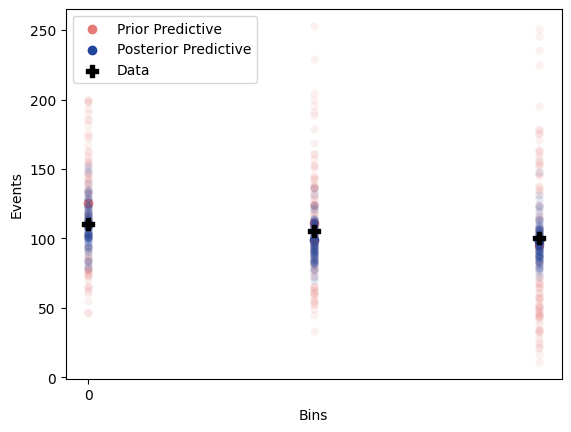

In [229]:
plotting.prior_posterior_predictives(model=model, data=data, post_pred=post_pred, prior_pred=prior_pred, bin_steps=5)

array([[<AxesSubplot: title={'center': 'normSys'}>,
        <AxesSubplot: title={'center': 'normSys'}>],
       [<AxesSubplot: title={'center': 'mu2'}>,
        <AxesSubplot: title={'center': 'mu2'}>],
       [<AxesSubplot: title={'center': 'uncorr_bkg'}>,
        <AxesSubplot: title={'center': 'uncorr_bkg'}>],
       [<AxesSubplot: title={'center': 'mu'}>,
        <AxesSubplot: title={'center': 'mu'}>]], dtype=object)

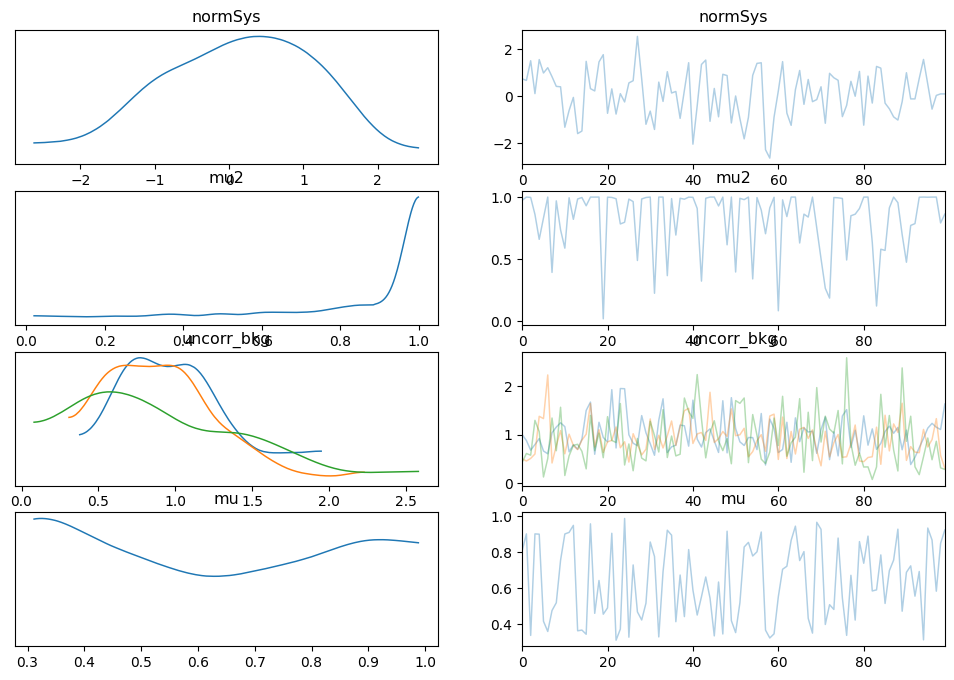

In [230]:
az.plot_trace(prior_pred.prior)

In [11]:
with open('ttbar_ljets_xsec_inclusive_pruned.json') as serialized:
    spec = json.load(serialized)

workspace = pyhf.Workspace(spec)
model = workspace.model()

data = workspace.data(model, include_auxdata=False)

unconstr_priors = {
    'ttbarXsec': {'type': 'HalfNormal_Unconstrained', 'sigma': [0.4]}
}

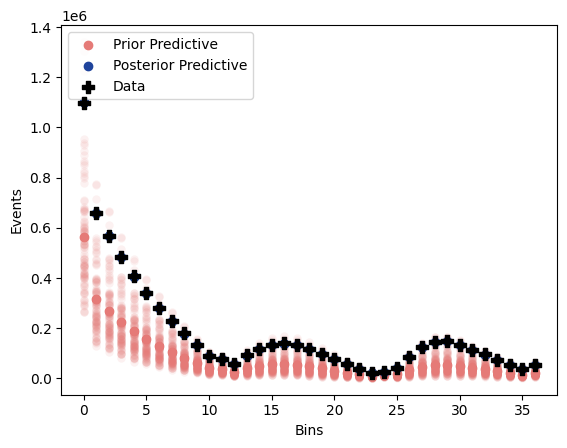

In [28]:
plotting.prior_posterior_predictives(model=model, data=data, post_pred=post_pred, prior_pred=prior_pred, bin_steps=5)

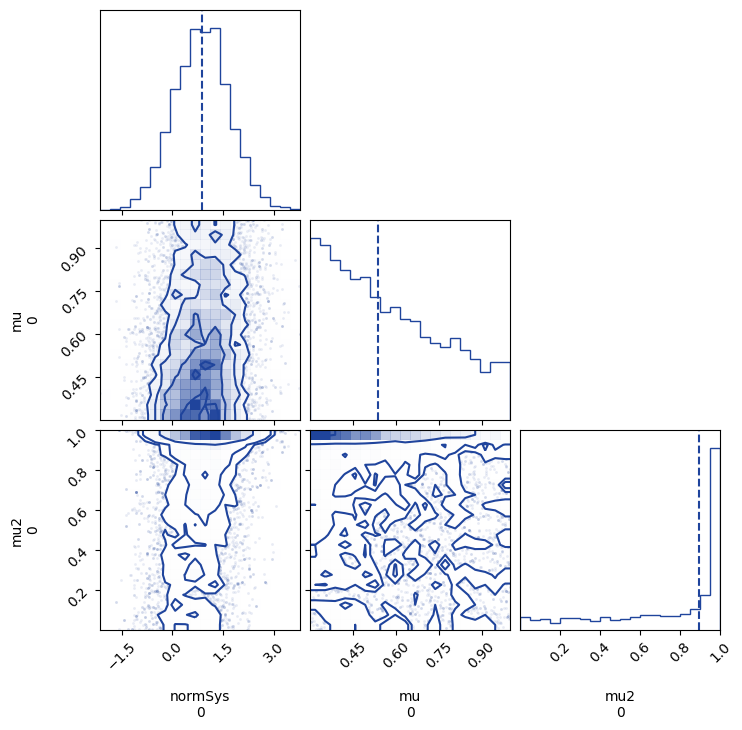

In [133]:
a = corner.corner(post_data.posterior, quantiles=[0.5], color = blue);

In [150]:
xx = np.linspace (0.001, 20, 20) 
for aux in [9.0, 4.652056901191849, 2.6]:
    plt.plot(xx, [sps.gamma.pdf(x, a=aux, scale=1/()) for x in xx], c='k', label='Conjugate Prior')
    plt.plot(xx, [sps.gamma.pdf(x, a=1, scale=1/(1)) for x in xx], '--', label='Ur-Prior')
plt.legend()

TypeError: unsupported operand type(s) for /: 'int' and 'tuple'

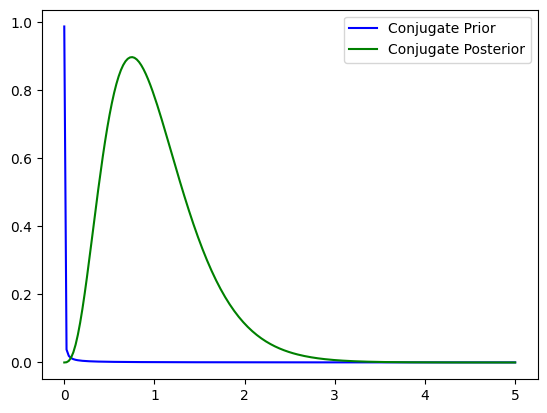

In [233]:
xx = np.linspace (0.001, 5, 200) 

aux = 4
alpha, beta = 0.001, 0.001

plt.plot(xx, [sps.gamma.pdf(x, a=alpha, scale=1/(beta)) for x in xx], c='b', label='Conjugate Prior')
plt.plot(xx, [sps.gamma.pdf(x, a=alpha + aux, scale=1/(aux*(beta + 1))) for x in xx], c='g', label='Conjugate Posterior')

plt.legend()